In [1]:
import GPy
from scipy import signal
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

from tqdm import tqdm
import haversine as hs
import networkx as nx

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


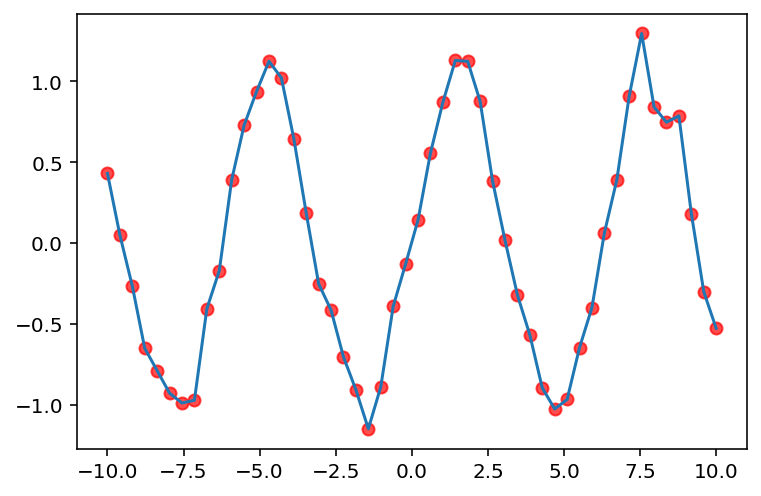

In [2]:
np.random.seed(0)
torch.random.manual_seed(0)

n_points = 50

x = torch.linspace(-10, 10, n_points)

y = torch.sin(x) + torch.randn(n_points)*0.1
plt.plot(x, y);
plt.scatter(x, y, c = 'red', alpha = 0.7)
plt.show()

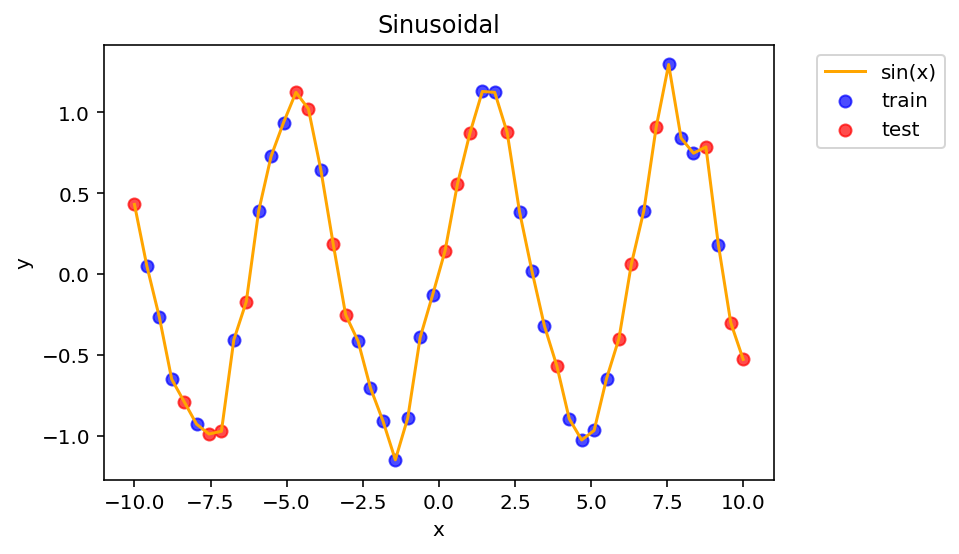

In [17]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4)
plt.plot(x, y, color = 'orange');
plt.scatter(train_x, train_y, c = 'blue', alpha = 0.7);
plt.scatter(test_x, test_y, c='red', alpha = 0.7);
plt.title('Sinusoidal');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x)', 'train', 'test'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [4]:
def get_distance(x1, x2):
    return abs(x1-x2)

def create_graph(x, y):
    
    G = nx.Graph()
    
    for i in range(len(x)):
            G.add_node(i, x = x[i], y = y[i])
            
            for j in range(i+1, i+8):
                if j >= len(x):
                    break
                distance = get_distance(x[i], x[j])
#                 G.add_edge(i, j, weight = 1/distance)
                G.add_edge(i, j)
    
    return G

In [5]:
G = create_graph(x, y)

In [6]:
node_features = [[G.nodes[node]['x']] for node in G.nodes]

edge_index = torch.tensor(list(G.edges())).t().contiguous()
y = torch.tensor([G.nodes[node]['y'] for node in G.nodes], dtype=torch.float).view(-1, 1)
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

n_train = [True if np.random.random() > 0.4 else False for i in range(len(G.nodes()))]
for i in range(len(G.nodes())):
    if n_train[i]:
        train_mask[i] = True
    else:
        test_mask[i] = True

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)


In [7]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 435.15it/s]


Train RMSE 0.052729465
Test RMSE 0.17770246


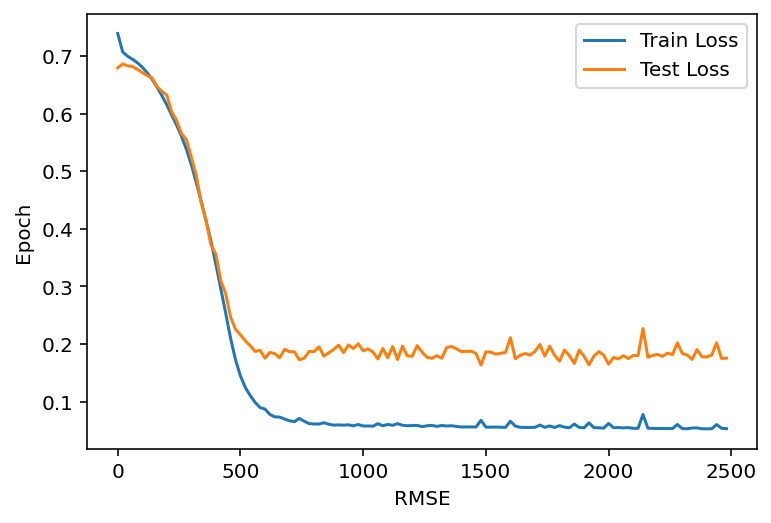

In [8]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE", train_rmse.numpy())
    print("Test RMSE", test_rmse.numpy())        

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

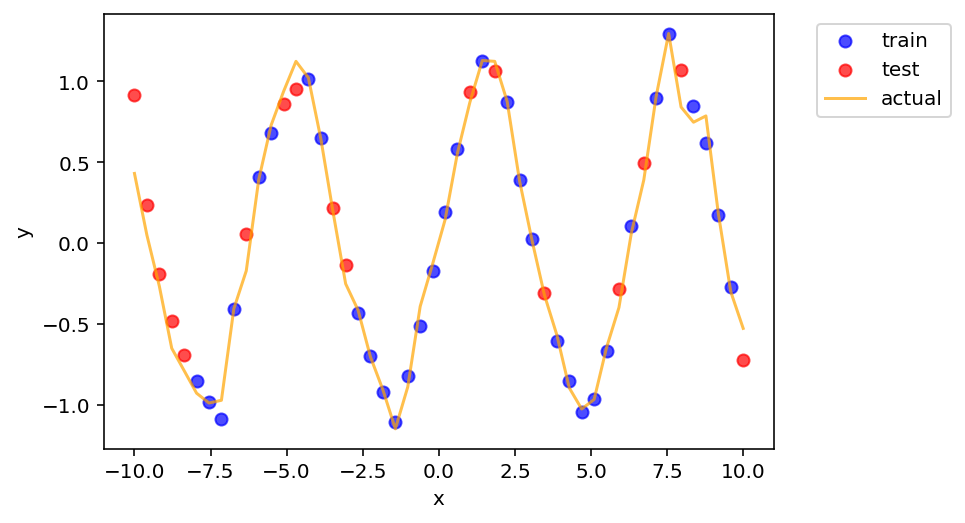

In [9]:
out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
train_preds = out[data.train_mask].squeeze().detach().numpy()
test_preds = out[data.test_mask].squeeze().detach().numpy()

plt.scatter(data.x[data.train_mask], train_preds, color = 'blue', label = 'train', alpha = 0.7)
plt.scatter(data.x[data.test_mask], test_preds, color = 'red', label = 'test', alpha = 0.7)
plt.plot(x, y, label = 'actual', color = 'orange', alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# IDW

In [10]:
def get_distance(x1, x2):
    return abs(x1-x2)

def create_graph(x, y):
    
    G = nx.Graph()
    
    for i in range(len(x)):
            G.add_node(i, x = x[i], y = y[i])
            
            for j in range(i+1, len(x)):
                distance = get_distance(x[i], x[j])
                G.add_edge(i, j, weight = 1/distance)
    
    return G

In [11]:
G = create_graph(x, y)

In [12]:
node_features = [[G.nodes[node]['x']] for node in G.nodes]

edge_weights = []
for edge in G.edges():
    edge_weights.append(G.get_edge_data(edge[0], edge[1])['weight'])

edge_index = torch.tensor(list(G.edges())).t().contiguous()
edge_weights = torch.tensor(edge_weights).t().contiguous()
y = torch.tensor([G.nodes[node]['y'] for node in G.nodes], dtype=torch.float).view(-1, 1)
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

n_train = [True if np.random.random() > 0.4 else False for i in range(len(G.nodes()))]
for i in range(len(G.nodes())):
    if n_train[i]:
        train_mask[i] = True
    else:
        test_mask[i] = True

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index,edge_weights = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask)


In [13]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weights)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 241.14it/s]


Train RMSE 0.18428636
Test RMSE 0.39564574


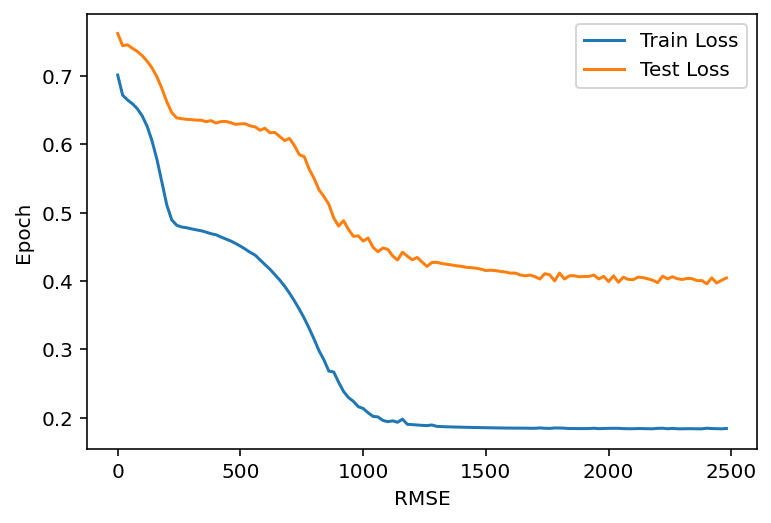

In [14]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device), data.edge_weights.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device), data.edge_weights.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device), data.edge_weights.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE", train_rmse.numpy())
    print("Test RMSE", test_rmse.numpy())        

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

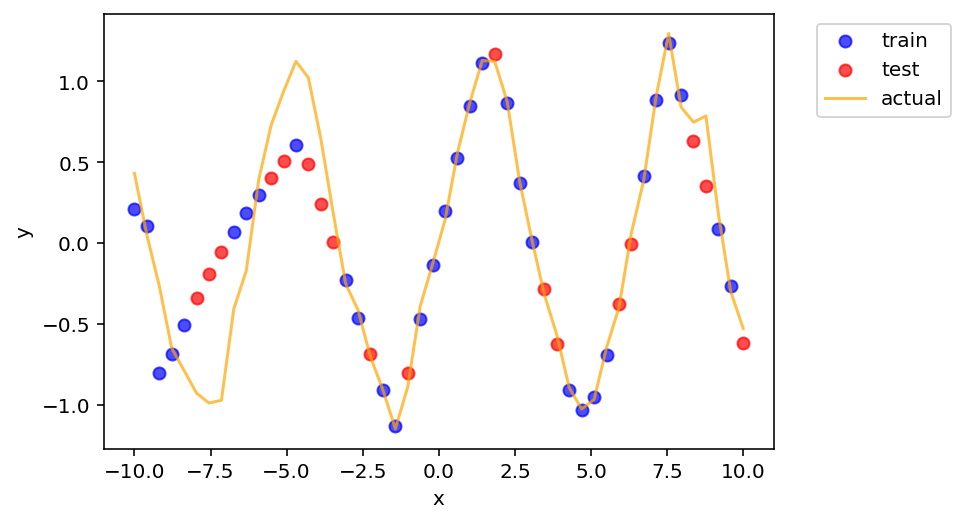

In [15]:
out = model(data.x.to(device), data.edge_index.to(device), data.edge_weights.to(device))  # Predicted PM values
train_preds = out[data.train_mask].squeeze().detach().numpy()
test_preds = out[data.test_mask].squeeze().detach().numpy()

plt.scatter(data.x[data.train_mask], train_preds, color = 'blue', label = 'train', alpha = 0.7)
plt.scatter(data.x[data.test_mask], test_preds, color = 'red', label = 'test', alpha = 0.7)
plt.plot(x, y, label = 'actual', color = 'orange', alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.show()